In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [14]:
import pandas as pd
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from gee_scripts.parameters import explain_vars, response_var, west_region_ids, center_region_ids


In [17]:
df = pd.read_csv("data/9_clean_training_data/all_training_data_with_extra_and_locations_and_precipSum.csv", parse_dates=["date"])

In [18]:
# Select relevant columns for clustering
columns_to_keep = ['id', 'lat', 'lon', 'elevation', 'aspect', 'slope', 'land_cov', 'canopy_height', 'distance', 'dir', 'acc', 'gwl_cm']

# Retain only the selected columns
df = df[df['region_id'].isin(center_region_ids)]
df = df[columns_to_keep]
df

,id,lat,lon,elevation,aspect,slope,land_cov,canopy_height,distance,dir,acc,gwl_cm
0,02_AHL_SBG-B076,3.937760,117.007750,33,45.067711,5.238249,160,24,4519.468722,1,1,-41.0
1,02_AHL_SBG-B076,3.937760,117.007750,33,45.067711,5.238249,160,24,4519.468722,1,1,-38.0
2,02_AHL_SBG-B076,3.937760,117.007750,33,45.067711,5.238249,160,24,4519.468722,1,1,-22.0
3,02_AHL_SBG-B076,3.937760,117.007750,33,45.067711,5.238249,160,24,4519.468722,1,1,-31.0
4,02_AHL_SBG-B101,3.931860,117.010120,22,326.247587,3.342748,30,15,5020.676546,128,36,-66.0
...,...,...,...,...,...,...,...,...,...,...,...,...
31542,kalteng1,-2.319728,114.058131,8,116.546267,2.074387,40,10,189.692997,128,16,-23.9
31543,kalteng1,-2.319728,114.058131,8,116.546267,2.074387,40,10,189.692997,128,16,-31.1
31544,kalteng1,-2.319728,114.058131,8,116.546267,2.074387,40,10,189.692997,128,16,-14.7
31545,kalteng1,-2.319728,114.058131,8,116.546267,2.074387,40,10,189.692997,128,16,-27.1


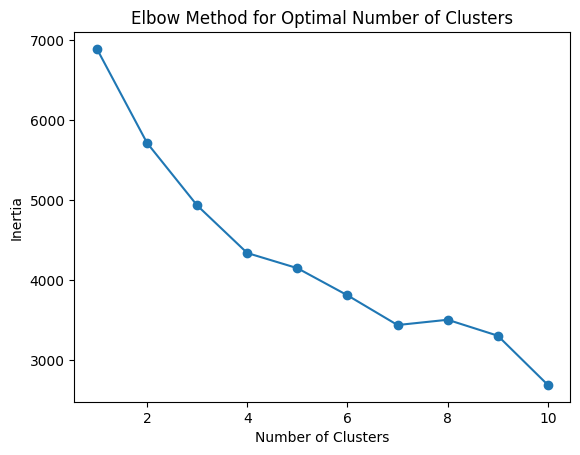

In [28]:


# Aggregate GWL measurements (e.g., by mean)
df_gwl_agg = df.groupby('id').agg({
    'lat': 'first',
    'lon': 'first',
    'elevation': 'first',
    'aspect': 'first',
    'slope': 'first',
    'land_cov': 'first',
    'canopy_height': 'first',
    'distance': 'first',
    'dir': 'first',
    'acc': 'first',
    'gwl_cm': 'mean'
}).reset_index()

# Normalize the data for clustering (excluding 'id', 'latitude', 'longitude')
features = df_gwl_agg.drop(columns=['id', 'lat', 'lon'])
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

# Determine the optimal number of clusters using the elbow method
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(normalized_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# From the elbow plot, choose the optimal number of clusters (e.g., k=3)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(normalized_features)

# Add cluster labels to the aggregated DataFrame
df_gwl_agg['cluster'] = clusters

In [29]:
df_gwl_agg[["id", "lat", "lon", "cluster"]].to_csv("data/14_featureEngineering/kalimantan_4clusters.csv", index=False)

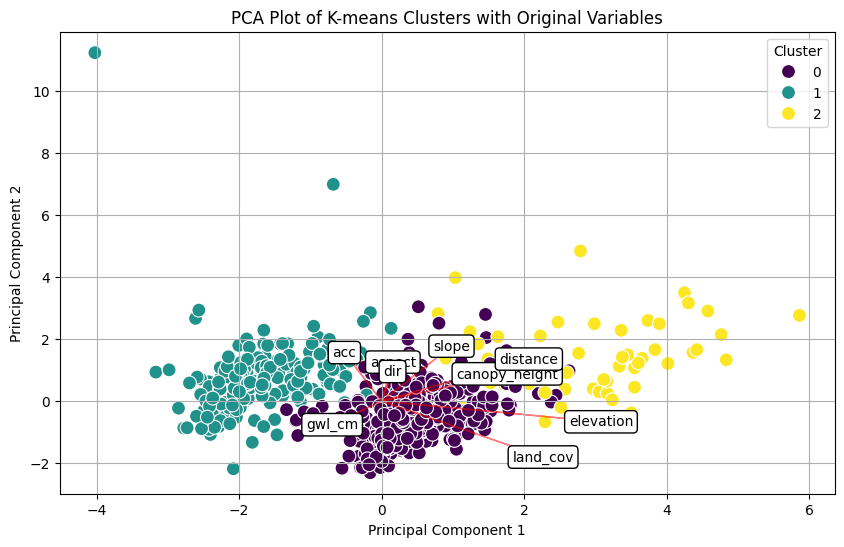

In [21]:
# Perform PCA to reduce the dimensionality to 2 components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(normalized_features)

# Create a DataFrame with the PCA components and the cluster labels
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['cluster'] = clusters

# Calculate the loading scores for the original variables
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Scale the loadings for exaggeration
scaling_factor = 3  # Increase this value to exaggerate the vectors more
loadings_exaggerated = loadings * scaling_factor

# Plot the PCA components with the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis', s=100)
plt.title('PCA Plot of K-means Clusters with Original Variables')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')

# Plot the exaggerated original variables as vectors
for i, var in enumerate(features.columns):
    plt.arrow(0, 0, loadings_exaggerated[i, 0], loadings_exaggerated[i, 1], color='r', alpha=0.5, head_width=0.2)
    plt.text(loadings_exaggerated[i, 0] * 1.15, loadings_exaggerated[i, 1] * 1.15, var, color='black', ha='center', va='center',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.grid()
plt.show()

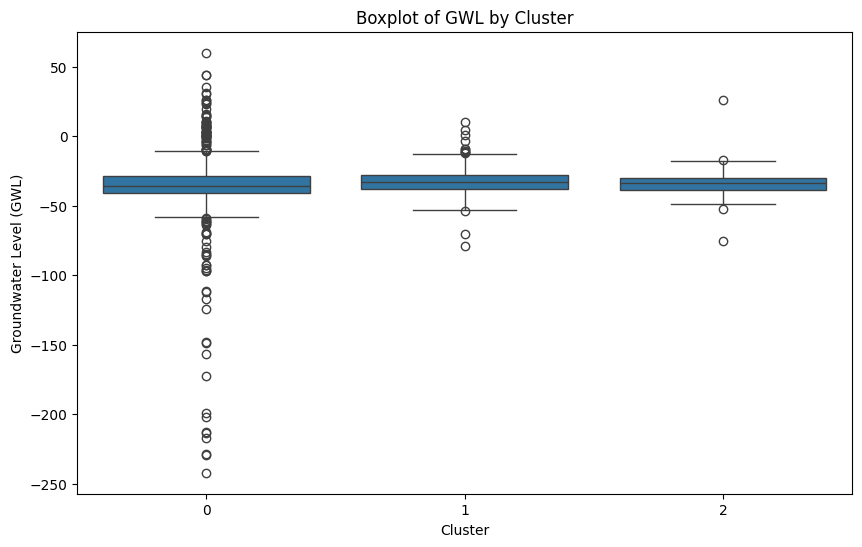

In [20]:
#make a boxplot to check for differences in the clusters
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='gwl_cm', data=df_gwl_agg)
plt.title('Boxplot of GWL by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Groundwater Level (GWL)')
plt.show()